# Quantum Algorithms Workshop: From Deutsch to Grover

**Duration:** 1.5 - 2 hours  
**Prerequisites:** Basic linear algebra, familiarity with quantum computing concepts  
**Tools:** Qiskit

---

## Workshop Overview

| Part | Topic | Duration |
|------|-------|----------|
| 1 | Qiskit Basics & Quantum Gates | 15-20 min |
| 2 | Deutsch's Algorithm | 15-20 min |
| 3 | Deutsch-Jozsa Algorithm | 15-20 min |
| 4 | Bernstein-Vazirani Algorithm | 15 min |
| 5 | Quantum Fourier Transform | 20-25 min |
| 6 | Grover's Search Algorithm | 20-25 min |

---

## Setup and Installation

First, let's install and import the necessary packages.

In [5]:
# Install Qiskit if not already installed
# !pip install qiskit qiskit-aer

# Core imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt

# Set up the simulator
simulator = AerSimulator()

print("✓ All imports successful!")

ModuleNotFoundError: No module named 'qiskit_aer'

---

# Part 1: Qiskit Basics (15-20 min)

Before diving into quantum algorithms, let's familiarize ourselves with Qiskit's circuit construction and simulation capabilities.

## Exercise 1.1: Your First Quantum Circuit

Create a simple circuit that:
1. Initializes a qubit in state |0⟩
2. Applies a Hadamard gate to create superposition
3. Measures the result

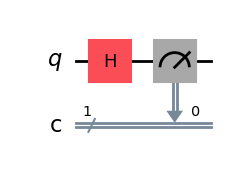

In [2]:
# Create a quantum circuit with 1 qubit and 1 classical bit
qc = QuantumCircuit(1, 1)

# Apply Hadamard gate to qubit 0
qc.h(0)

# Measure qubit 0 into classical bit 0
qc.measure(0, 0)

# Visualize the circuit
qc.draw('mpl')

In [4]:
# Run the circuit on the simulator
job = simulator.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()

print(f"Results: {counts}")
plot_histogram(counts)

NameError: name 'simulator' is not defined

**Discussion:** What do you observe? Why are the counts approximately 50-50?

## Exercise 1.2: The Hadamard Gate

The Hadamard gate transforms:
- $|0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) = |+\rangle$
- $|1\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) = |-\rangle$

Let's verify this by examining the statevector.

In [ ]:
# Create circuit without measurement to see the statevector
qc_h0 = QuantumCircuit(1)
qc_h0.h(0)

# Get the statevector
state = Statevector.from_instruction(qc_h0)
print("H|0⟩ =", state.data)
print(f"Expected: [1/√2, 1/√2] = [{1/np.sqrt(2):.4f}, {1/np.sqrt(2):.4f}]")

In [ ]:
# Now try H|1⟩
qc_h1 = QuantumCircuit(1)
qc_h1.x(0)  # Flip to |1⟩
qc_h1.h(0)  # Apply Hadamard

state = Statevector.from_instruction(qc_h1)
print("H|1⟩ =", state.data)
print(f"Expected: [1/√2, -1/√2] = [{1/np.sqrt(2):.4f}, {-1/np.sqrt(2):.4f}]")

## Exercise 1.3: Multi-Qubit States and Entanglement

Create a Bell state: $|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$

In [ ]:
# Create a 2-qubit circuit
bell = QuantumCircuit(2, 2)

# Create Bell state
bell.h(0)       # Put qubit 0 in superposition
bell.cx(0, 1)   # CNOT: qubit 0 controls qubit 1

bell.draw('mpl')

In [ ]:
# Examine the statevector
bell_no_measure = QuantumCircuit(2)
bell_no_measure.h(0)
bell_no_measure.cx(0, 1)

state = Statevector.from_instruction(bell_no_measure)
print("Bell state |Φ⁺⟩:")
print(f"|00⟩ amplitude: {state.data[0]:.4f}")
print(f"|01⟩ amplitude: {state.data[1]:.4f}")
print(f"|10⟩ amplitude: {state.data[2]:.4f}")
print(f"|11⟩ amplitude: {state.data[3]:.4f}")

In [ ]:
# Measure and verify correlations
bell.measure([0, 1], [0, 1])
job = simulator.run(bell, shots=1000)
counts = job.result().get_counts()

print(f"Bell state measurements: {counts}")
plot_histogram(counts)

**Discussion:** Notice that we only get |00⟩ and |11⟩, never |01⟩ or |10⟩. This is the signature of entanglement!

---

# Part 2: Deutsch's Algorithm (15-20 min)

## Problem Statement

Given a function $f: \{0,1\} \rightarrow \{0,1\}$, determine if $f$ is:
- **Constant:** $f(0) = f(1)$
- **Balanced:** $f(0) \neq f(1)$

**Classical:** Requires 2 queries  
**Quantum:** Requires only 1 query!

### The Oracle

The oracle implements: $U_f|x\rangle|y\rangle = |x\rangle|y \oplus f(x)\rangle$

In [ ]:
def deutsch_oracle(qc, oracle_type):
    """
    Implements the oracle for Deutsch's algorithm.
    
    There are 4 possible functions:
    - 'constant_0': f(x) = 0 for all x
    - 'constant_1': f(x) = 1 for all x  
    - 'balanced_identity': f(x) = x
    - 'balanced_not': f(x) = NOT(x)
    """
    if oracle_type == 'constant_0':
        # f(x) = 0: Do nothing
        pass
    elif oracle_type == 'constant_1':
        # f(x) = 1: Always flip the output qubit
        qc.x(1)
    elif oracle_type == 'balanced_identity':
        # f(x) = x: CNOT controlled by input
        qc.cx(0, 1)
    elif oracle_type == 'balanced_not':
        # f(x) = NOT(x): CNOT + X on input side
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)
    
    return qc

## Exercise 2.1: Implement Deutsch's Algorithm

In [ ]:
def deutsch_algorithm(oracle_type):
    """
    Deutsch's algorithm implementation.
    
    Circuit:
    |0⟩ ─ H ─ oracle ─ H ─ Measure
    |1⟩ ─ H ─────────────────────
    """
    qc = QuantumCircuit(2, 1)
    
    # Step 1: Prepare |0⟩|1⟩
    qc.x(1)  # Set second qubit to |1⟩
    
    # Step 2: Apply Hadamard to both qubits
    qc.h(0)
    qc.h(1)
    
    qc.barrier()
    
    # Step 3: Apply the oracle
    deutsch_oracle(qc, oracle_type)
    
    qc.barrier()
    
    # Step 4: Apply Hadamard to first qubit
    qc.h(0)
    
    # Step 5: Measure first qubit
    qc.measure(0, 0)
    
    return qc

# Test with all oracle types
oracle_types = ['constant_0', 'constant_1', 'balanced_identity', 'balanced_not']

for oracle in oracle_types:
    qc = deutsch_algorithm(oracle)
    job = simulator.run(qc, shots=1000)
    counts = job.result().get_counts()
    result = "CONSTANT" if '0' in counts and counts.get('0', 0) > 500 else "BALANCED"
    print(f"Oracle: {oracle:20s} → Measurement: {counts} → {result}")

In [ ]:
# Visualize the circuit for one case
qc = deutsch_algorithm('balanced_identity')
qc.draw('mpl')

## Exercise 2.2: Understanding Phase Kickback

The key insight is **phase kickback**: when the second qubit is in state $|-\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$, the oracle transforms:

$$U_f|x\rangle|-\rangle = (-1)^{f(x)}|x\rangle|-\rangle$$

The phase "kicks back" to the control qubit!

In [ ]:
# Demonstrate phase kickback
# Let's trace through the algorithm step by step

def trace_deutsch(oracle_type):
    print(f"\n=== Tracing Deutsch's Algorithm with {oracle_type} ===")
    
    # Initial state |01⟩
    qc = QuantumCircuit(2)
    qc.x(1)
    state = Statevector.from_instruction(qc)
    print(f"After X on q1: |01⟩")
    
    # After Hadamards
    qc.h(0)
    qc.h(1)
    state = Statevector.from_instruction(qc)
    print(f"After H⊗H: |+⟩|−⟩")
    
    # After oracle
    deutsch_oracle(qc, oracle_type)
    state = Statevector.from_instruction(qc)
    print(f"After Oracle: State amplitudes = {np.round(state.data, 3)}")
    
    # After final Hadamard on first qubit
    qc.h(0)
    state = Statevector.from_instruction(qc)
    print(f"After final H: State amplitudes = {np.round(state.data, 3)}")
    
    # What's the probability of measuring |0⟩ on first qubit?
    prob_0 = abs(state.data[0])**2 + abs(state.data[1])**2
    prob_1 = abs(state.data[2])**2 + abs(state.data[3])**2
    print(f"P(first qubit = 0) = {prob_0:.3f}")
    print(f"P(first qubit = 1) = {prob_1:.3f}")

trace_deutsch('constant_0')
trace_deutsch('balanced_identity')

---

# Part 3: Deutsch-Jozsa Algorithm (15-20 min)

## Problem Statement

Given a function $f: \{0,1\}^n \rightarrow \{0,1\}$ that is **promised** to be either:
- **Constant:** $f(x) = c$ for all $x$
- **Balanced:** $f(x) = 0$ for exactly half of inputs, $f(x) = 1$ for the other half

Determine which case applies.

**Classical:** Requires up to $2^{n-1} + 1$ queries  
**Quantum:** Requires only 1 query!

In [ ]:
def dj_oracle(qc, n, oracle_type):
    """
    Oracle for Deutsch-Jozsa algorithm.
    
    oracle_type can be:
    - 'constant_0': f(x) = 0
    - 'constant_1': f(x) = 1
    - 'balanced': f(x) = x₀ ⊕ x₁ ⊕ ... (parity function)
    """
    if oracle_type == 'constant_0':
        pass  # Do nothing
    elif oracle_type == 'constant_1':
        qc.x(n)  # Flip the output qubit
    elif oracle_type == 'balanced':
        # Balanced oracle: CNOT from each input qubit to output
        for i in range(n):
            qc.cx(i, n)
    return qc

## Exercise 3.1: Implement Deutsch-Jozsa for n qubits

In [ ]:
def deutsch_jozsa(n, oracle_type):
    """
    Deutsch-Jozsa algorithm for n input qubits.
    
    Circuit:
    |0⟩^⊗n ─ H^⊗n ─ Oracle ─ H^⊗n ─ Measure
    |1⟩    ─ H     ─────────────────────────
    """
    # n input qubits + 1 output qubit
    qc = QuantumCircuit(n + 1, n)
    
    # Initialize output qubit to |1⟩
    qc.x(n)
    
    # Apply Hadamard to all qubits
    for i in range(n + 1):
        qc.h(i)
    
    qc.barrier()
    
    # Apply oracle
    dj_oracle(qc, n, oracle_type)
    
    qc.barrier()
    
    # Apply Hadamard to input qubits
    for i in range(n):
        qc.h(i)
    
    # Measure input qubits
    for i in range(n):
        qc.measure(i, i)
    
    return qc

# Test with 4 qubits
n = 4
for oracle in ['constant_0', 'constant_1', 'balanced']:
    qc = deutsch_jozsa(n, oracle)
    job = simulator.run(qc, shots=1000)
    counts = job.result().get_counts()
    
    # If we measure all zeros, it's constant; otherwise balanced
    all_zeros = '0' * n
    result = "CONSTANT" if all_zeros in counts and counts[all_zeros] > 500 else "BALANCED"
    print(f"Oracle: {oracle:12s} → Measurement: {counts} → {result}")

In [ ]:
# Visualize the circuit for n=3
qc = deutsch_jozsa(3, 'balanced')
qc.draw('mpl')

## Exercise 3.2: Custom Balanced Oracle

**Your turn!** Create a balanced oracle that implements $f(x) = x_0 \oplus x_2$ (XOR of first and third bits only).

In [ ]:
def custom_balanced_oracle(qc, n):
    """
    TODO: Implement f(x) = x_0 ⊕ x_2
    Hint: Use CNOT gates from qubits 0 and 2 to the output qubit (qubit n)
    """
    # YOUR CODE HERE
    qc.cx(0, n)  # CNOT from qubit 0
    qc.cx(2, n)  # CNOT from qubit 2
    return qc

# Test the custom oracle
n = 4
qc = QuantumCircuit(n + 1, n)
qc.x(n)
for i in range(n + 1):
    qc.h(i)
qc.barrier()
custom_balanced_oracle(qc, n)
qc.barrier()
for i in range(n):
    qc.h(i)
for i in range(n):
    qc.measure(i, i)

job = simulator.run(qc, shots=1000)
counts = job.result().get_counts()
print(f"Custom balanced oracle result: {counts}")
print("Expected: NOT all zeros (balanced function)")

---

# Part 4: Bernstein-Vazirani Algorithm (15 min)

## Problem Statement

Given $f(x) = a \cdot x \pmod{2}$ for some unknown $n$-bit string $a$, find $a$.

**Classical:** Requires $n$ queries (one per bit of $a$)  
**Quantum:** Requires only 1 query!

This uses the same circuit structure as Deutsch-Jozsa!

In [ ]:
def bv_oracle(qc, n, secret_string):
    """
    Oracle for Bernstein-Vazirani.
    Implements f(x) = a · x (mod 2) where a is the secret_string.
    
    For each bit of 'a' that is 1, add a CNOT from that qubit to the output.
    """
    for i, bit in enumerate(reversed(secret_string)):
        if bit == '1':
            qc.cx(i, n)
    return qc

def bernstein_vazirani(n, secret_string):
    """
    Bernstein-Vazirani algorithm.
    Same structure as Deutsch-Jozsa!
    """
    qc = QuantumCircuit(n + 1, n)
    
    # Initialize output qubit to |1⟩
    qc.x(n)
    
    # Apply Hadamard to all qubits
    for i in range(n + 1):
        qc.h(i)
    
    qc.barrier()
    
    # Apply oracle
    bv_oracle(qc, n, secret_string)
    
    qc.barrier()
    
    # Apply Hadamard to input qubits
    for i in range(n):
        qc.h(i)
    
    # Measure input qubits
    for i in range(n):
        qc.measure(i, i)
    
    return qc

## Exercise 4.1: Find the Hidden String

In [ ]:
# Test with various secret strings
secret_strings = ['101', '110', '1101', '10101010']

for secret in secret_strings:
    n = len(secret)
    qc = bernstein_vazirani(n, secret)
    job = simulator.run(qc, shots=1000)
    counts = job.result().get_counts()
    
    # The measurement should give us the secret string directly!
    found = max(counts, key=counts.get)
    print(f"Secret: {secret} | Measured: {found} | Match: {secret == found}")

In [ ]:
# Visualize the circuit
qc = bernstein_vazirani(5, '10101')
qc.draw('mpl')

## Exercise 4.2: Interactive Challenge

**Teacher's challenge:** The teacher picks a secret string, and students must find it with just ONE quantum query!

In [ ]:
# Teacher: Set your secret string here (don't show the students!)
TEACHER_SECRET = '11011'  # Change this!

def teacher_oracle(qc, n):
    """Hidden oracle - students don't see the implementation!"""
    for i, bit in enumerate(reversed(TEACHER_SECRET)):
        if bit == '1':
            qc.cx(i, n)
    return qc

# Students run this to find the secret
n = len(TEACHER_SECRET)
qc = QuantumCircuit(n + 1, n)
qc.x(n)
for i in range(n + 1):
    qc.h(i)
qc.barrier()
teacher_oracle(qc, n)
qc.barrier()
for i in range(n):
    qc.h(i)
for i in range(n):
    qc.measure(i, i)

job = simulator.run(qc, shots=1)
counts = job.result().get_counts()
print(f"With just ONE query, the secret is: {list(counts.keys())[0]}")

---

# Part 5: Quantum Fourier Transform (20-25 min)

## The QFT Definition

The Quantum Fourier Transform maps:

$$|x\rangle \rightarrow \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2\pi i xy/N} |y\rangle$$

where $N = 2^n$.

### Key Properties
- Unitary transformation
- Implements $O(n^2)$ gates (exponential speedup over classical FFT in gate count!)
- Essential for period finding and Shor's algorithm

In [ ]:
def qft_rotations(qc, n):
    """Perform the core QFT rotations on qubits 0 to n-1."""
    if n == 0:
        return qc
    
    n -= 1
    qc.h(n)
    
    for qubit in range(n):
        # Controlled rotation by π/2^(n-qubit)
        qc.cp(np.pi / 2**(n - qubit), qubit, n)
    
    # Recursive call
    qft_rotations(qc, n)

def swap_registers(qc, n):
    """Swap qubits to reverse the order (QFT outputs in reversed order)."""
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    return qc

def qft(qc, n):
    """Complete QFT on first n qubits of circuit qc."""
    qft_rotations(qc, n)
    swap_registers(qc, n)
    return qc

## Exercise 5.1: Build and Visualize the QFT Circuit

In [ ]:
# Create a 3-qubit QFT circuit
n = 3
qc_qft = QuantumCircuit(n)
qft(qc_qft, n)

qc_qft.draw('mpl')

## Exercise 5.2: Verify QFT Properties

The QFT should transform computational basis states into the Fourier basis. Let's verify!

In [ ]:
def analyze_qft_output(input_state, n):
    """Analyze the QFT output for a given input state."""
    qc = QuantumCircuit(n)
    
    # Prepare the input state (as binary)
    for i, bit in enumerate(reversed(input_state)):
        if bit == '1':
            qc.x(i)
    
    # Apply QFT
    qft(qc, n)
    
    # Get statevector
    state = Statevector.from_instruction(qc)
    
    print(f"\nQFT|{input_state}⟩:")
    N = 2**n
    x = int(input_state, 2)
    
    for y in range(N):
        amplitude = state.data[y]
        expected_phase = 2 * np.pi * x * y / N
        expected = np.exp(1j * expected_phase) / np.sqrt(N)
        print(f"  |{y:0{n}b}⟩: {amplitude:.4f} (expected: {expected:.4f})")

# Test with different input states
n = 3
analyze_qft_output('000', n)
analyze_qft_output('001', n)
analyze_qft_output('010', n)

## Exercise 5.3: QFT as a Period Finder

When applied to a periodic superposition, the QFT reveals the period in the frequency domain.

Let's create a state with period r and see what happens!

In [ ]:
def create_periodic_state(n, period, offset=0):
    """
    Create a superposition of states at positions offset, offset+period, offset+2*period, ...
    This simulates what happens after measuring the second register in period finding.
    """
    N = 2**n
    qc = QuantumCircuit(n)
    
    # Create the periodic state manually using initialize
    state = np.zeros(N, dtype=complex)
    positions = range(offset, N, period)
    num_positions = len(list(positions))
    
    for pos in range(offset, N, period):
        state[pos] = 1.0 / np.sqrt(num_positions)
    
    qc.initialize(state, range(n))
    return qc

# Create a periodic state with period 4 on 4 qubits
n = 4
period = 4

qc = create_periodic_state(n, period, offset=0)
state_before = Statevector.from_instruction(qc)

# Apply QFT
qft(qc, n)
state_after = Statevector.from_instruction(qc)

# Plot the probability distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Before QFT
probs_before = np.abs(state_before.data)**2
axes[0].bar(range(2**n), probs_before)
axes[0].set_xlabel('State')
axes[0].set_ylabel('Probability')
axes[0].set_title(f'Before QFT (period = {period})')

# After QFT
probs_after = np.abs(state_after.data)**2
axes[1].bar(range(2**n), probs_after)
axes[1].set_xlabel('State')
axes[1].set_ylabel('Probability')
axes[1].set_title('After QFT')

plt.tight_layout()
plt.show()

# Find the peaks
print(f"\nPeaks after QFT (period = {period}, N = {2**n}):")
for i, p in enumerate(probs_after):
    if p > 0.01:
        print(f"  State {i}: probability = {p:.4f}, corresponds to k*N/r = {i}")
        
print(f"\nExpected peaks at multiples of N/r = {2**n // period}")

## Exercise 5.4: Build QFT Without Swaps (For the Curious)

Some implementations skip the final swap gates. The output is in bit-reversed order, but this can be accounted for classically.

In [ ]:
# Compare with Qiskit's built-in QFT
from qiskit.circuit.library import QFT as QiskitQFT

# Our implementation
n = 4
our_qft = QuantumCircuit(n)
qft(our_qft, n)

# Qiskit's implementation
qiskit_qft = QiskitQFT(n)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
our_qft.draw('mpl', ax=axes[0])
axes[0].set_title('Our QFT')
qiskit_qft.draw('mpl', ax=axes[1])
axes[1].set_title("Qiskit's QFT")
plt.tight_layout()
plt.show()

---

# Part 6: Grover's Search Algorithm (20-25 min)

## Problem Statement

Given a function $f: \{0,1,...,N-1\} \rightarrow \{0,1\}$, find the unique $w$ such that $f(w) = 1$.

**Classical:** $O(N)$ queries  
**Quantum:** $O(\sqrt{N})$ queries - **proven optimal!**

### Algorithm Structure
1. Initialize uniform superposition
2. Repeat $O(\sqrt{N})$ times:
   - Apply oracle (phase flip on $|w\rangle$)
   - Apply diffusion operator (inversion about average)
3. Measure

In [ ]:
def grover_oracle(qc, n, marked_states):
    """
    Oracle that flips the phase of marked states.
    Implements: U_w = I - 2|w⟩⟨w| for each marked state.
    
    For simplicity, we use a multi-controlled Z gate.
    """
    for marked in marked_states:
        # Convert marked state to list of bit values
        mark_bits = [int(b) for b in marked]
        
        # Apply X gates to qubits that should be 0 (to match the |11...1⟩ pattern)
        for i, bit in enumerate(reversed(mark_bits)):
            if bit == 0:
                qc.x(i)
        
        # Multi-controlled Z gate
        if n == 2:
            qc.cz(0, 1)
        else:
            # For n > 2, use multi-controlled Z
            qc.h(n-1)
            qc.mcx(list(range(n-1)), n-1)  # Multi-controlled X
            qc.h(n-1)
        
        # Undo the X gates
        for i, bit in enumerate(reversed(mark_bits)):
            if bit == 0:
                qc.x(i)
    
    return qc

def diffusion_operator(qc, n):
    """
    Diffusion operator: 2|s⟩⟨s| - I
    where |s⟩ is the uniform superposition.
    
    Implementation: H^⊗n (2|0⟩⟨0| - I) H^⊗n
    """
    # Apply H to all qubits
    for i in range(n):
        qc.h(i)
    
    # Apply X to all qubits
    for i in range(n):
        qc.x(i)
    
    # Multi-controlled Z (phase flip on |0...0⟩ after X gates means |1...1⟩)
    if n == 2:
        qc.cz(0, 1)
    else:
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
    
    # Apply X to all qubits
    for i in range(n):
        qc.x(i)
    
    # Apply H to all qubits
    for i in range(n):
        qc.h(i)
    
    return qc

## Exercise 6.1: Implement Grover's Algorithm

In [ ]:
def grover_algorithm(n, marked_states, num_iterations=None):
    """
    Complete Grover's algorithm.
    
    Parameters:
    - n: number of qubits
    - marked_states: list of states to search for (as bit strings)
    - num_iterations: number of Grover iterations (default: optimal)
    """
    N = 2**n
    M = len(marked_states)  # Number of marked states
    
    # Optimal number of iterations
    if num_iterations is None:
        num_iterations = int(np.floor(np.pi/4 * np.sqrt(N/M)))
    
    print(f"N = {N}, M = {M}, optimal iterations ≈ {np.pi/4 * np.sqrt(N/M):.2f}")
    print(f"Using {num_iterations} iterations")
    
    qc = QuantumCircuit(n, n)
    
    # Initialize uniform superposition
    for i in range(n):
        qc.h(i)
    
    # Apply Grover iterations
    for iteration in range(num_iterations):
        qc.barrier()
        # Oracle
        grover_oracle(qc, n, marked_states)
        qc.barrier()
        # Diffusion
        diffusion_operator(qc, n)
    
    # Measure
    qc.barrier()
    for i in range(n):
        qc.measure(i, i)
    
    return qc

# Example: Search for '101' in a 3-qubit system
n = 3
marked = ['101']

qc = grover_algorithm(n, marked)
qc.draw('mpl')

In [ ]:
# Run the circuit
job = simulator.run(qc, shots=1000)
counts = job.result().get_counts()

print(f"\nSearching for: {marked}")
print(f"Results: {counts}")

# Success probability
success_prob = counts.get(marked[0], 0) / 1000
print(f"Success probability: {success_prob:.1%}")

plot_histogram(counts)

## Exercise 6.2: Effect of Iteration Count

What happens if we use too few or too many iterations?

In [ ]:
n = 4
marked = ['1011']
N = 2**n

# Theoretical probability as function of iterations
def grover_probability(k, N, M=1):
    """Probability of success after k Grover iterations."""
    theta = np.arcsin(np.sqrt(M/N))
    return np.sin((2*k + 1) * theta)**2

# Test with different iteration counts
iterations_to_test = [0, 1, 2, 3, 4, 5, 6, 7, 8]
success_probs = []
theoretical_probs = []

for num_iter in iterations_to_test:
    qc = grover_algorithm(n, marked, num_iterations=num_iter)
    job = simulator.run(qc, shots=1000)
    counts = job.result().get_counts()
    
    success = counts.get(marked[0], 0) / 1000
    success_probs.append(success)
    theoretical_probs.append(grover_probability(num_iter, N))

# Plot
plt.figure(figsize=(10, 5))
plt.bar(np.array(iterations_to_test) - 0.2, success_probs, 0.4, label='Measured', color='blue')
plt.bar(np.array(iterations_to_test) + 0.2, theoretical_probs, 0.4, label='Theoretical', color='orange')
plt.xlabel('Number of Iterations')
plt.ylabel('Success Probability')
plt.title(f"Grover's Algorithm: Effect of Iteration Count (n={n}, N={N})")
plt.legend()
plt.xticks(iterations_to_test)
plt.axhline(y=1/N, color='red', linestyle='--', label='Random guess')
plt.show()

optimal = int(np.floor(np.pi/4 * np.sqrt(N)))
print(f"\nOptimal iterations: {optimal}")
print("Note: Too many iterations can DECREASE the success probability!")

## Exercise 6.3: Multiple Marked States

Grover's algorithm also works when there are multiple solutions!

In [ ]:
n = 4
# Mark all states that end in '11'
marked = ['0011', '0111', '1011', '1111']

qc = grover_algorithm(n, marked)
job = simulator.run(qc, shots=1000)
counts = job.result().get_counts()

print(f"Searching for: {marked}")
print(f"Results: {counts}")

# Total success probability
total_success = sum(counts.get(m, 0) for m in marked) / 1000
print(f"Total success probability: {total_success:.1%}")

plot_histogram(counts)

## Exercise 6.4: Visualizing Grover's Geometry

Grover's algorithm can be understood as rotations in a 2D plane spanned by:
- $|w\rangle$ (marked state)
- $|w^\perp\rangle$ (superposition of unmarked states)

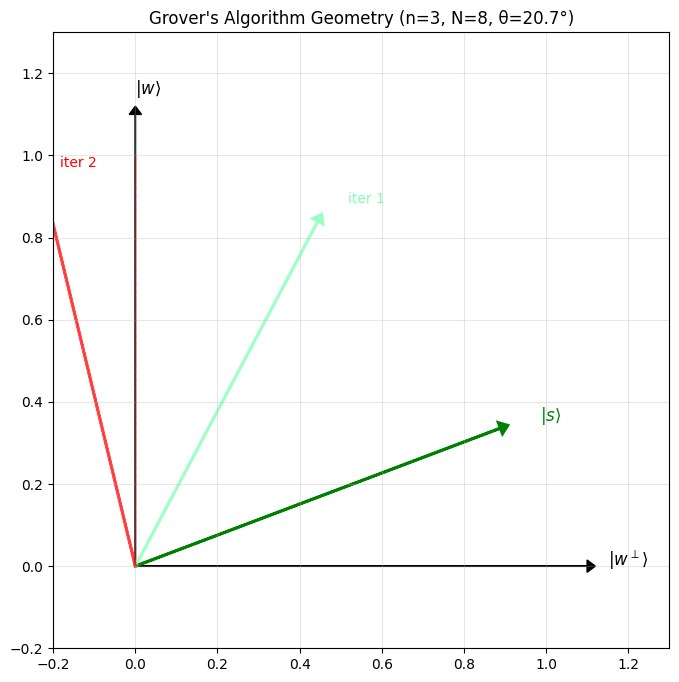

Initial angle θ = 20.70°
Rotation per iteration: 2θ = 41.41°
Optimal iterations: 2


In [3]:
def visualize_grover_geometry(n, num_iterations):
    """Visualize Grover's algorithm as rotations in 2D."""
    N = 2**n
    theta = np.arcsin(1/np.sqrt(N))  # Initial angle with |w⊥⟩
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw axes
    ax.arrow(0, 0, 1.1, 0, head_width=0.03, head_length=0.02, fc='black', ec='black')
    ax.arrow(0, 0, 0, 1.1, head_width=0.03, head_length=0.02, fc='black', ec='black')
    ax.text(1.15, 0, '$|w^\\perp\\rangle$', fontsize=12)
    ax.text(0, 1.15, '$|w\\rangle$', fontsize=12)
    
    # Draw initial state |s⟩
    s_x = np.cos(theta)
    s_y = np.sin(theta)
    ax.arrow(0, 0, s_x*0.95, s_y*0.95, head_width=0.03, head_length=0.02, 
             fc='green', ec='green', linewidth=2)
    ax.text(s_x + 0.05, s_y, '$|s\\rangle$', fontsize=12, color='green')
    
    # Draw each iteration
    colors = plt.cm.rainbow(np.linspace(0, 1, num_iterations + 1))
    
    current_angle = theta
    for i in range(num_iterations):
        new_angle = current_angle + 2 * theta  # Each iteration rotates by 2θ
        
        x = np.cos(new_angle)
        y = np.sin(new_angle)
        
        ax.arrow(0, 0, x*0.95, y*0.95, head_width=0.03, head_length=0.02,
                fc=colors[i+1], ec=colors[i+1], linewidth=2, alpha=0.7)
        ax.text(x + 0.05, y, f'iter {i+1}', fontsize=10, color=colors[i+1])
        
        current_angle = new_angle
    
    # Draw the target |w⟩ direction
    ax.plot([0, 0], [0, 1], 'r--', linewidth=1, alpha=0.5)
    
    ax.set_xlim(-0.2, 1.3)
    ax.set_ylim(-0.2, 1.3)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Grover's Algorithm Geometry (n={n}, N={N}, θ={np.degrees(theta):.1f}°)")
    
    plt.show()
    
    print(f"Initial angle θ = {np.degrees(theta):.2f}°")
    print(f"Rotation per iteration: 2θ = {np.degrees(2*theta):.2f}°")
    print(f"Optimal iterations: {int(np.floor(np.pi/4/theta))}")

visualize_grover_geometry(n=3, num_iterations=2)

---

# Summary and Discussion

## Key Takeaways

| Algorithm | Problem | Classical | Quantum | Speedup |
|-----------|---------|-----------|---------|----------|
| Deutsch | Is f constant or balanced? (1-bit) | 2 queries | 1 query | 2× |
| Deutsch-Jozsa | Is f constant or balanced? (n-bit) | O(2ⁿ) | 1 query | Exponential |
| Bernstein-Vazirani | Find hidden string a | n queries | 1 query | n× |
| Simon's | Find hidden period (in Z₂ⁿ) | O(2^(n/2)) | O(n) | Exponential |
| Shor's | Period finding / Factoring | O(exp(n^(1/3))) | O(poly(n)) | Exponential |
| Grover | Unstructured search | O(N) | O(√N) | Quadratic |

## Key Quantum Techniques

1. **Quantum Parallelism:** Superposition allows evaluating f on all inputs simultaneously
2. **Phase Kickback:** Oracle converts bit information to phase information
3. **Quantum Interference:** Hadamard transforms create constructive/destructive interference
4. **Amplitude Amplification:** Grover's diffusion operator amplifies correct answers

---

# Bonus Exercises (If Time Permits)

## Bonus 1: Implement Inverse QFT

In [ ]:
def inverse_qft(qc, n):
    """Inverse QFT - just the adjoint of QFT."""
    # Swap first
    swap_registers(qc, n)
    
    # Inverse rotations (bottom-up, conjugate phases)
    for target in range(n):
        for control in range(target):
            qc.cp(-np.pi / 2**(target - control), control, target)
        qc.h(target)
    
    return qc

# Verify: QFT followed by inverse QFT should give identity
n = 3
qc = QuantumCircuit(n)

# Prepare some state
qc.x(0)
qc.h(1)

state_before = Statevector.from_instruction(qc)

# Apply QFT then inverse QFT
qft(qc, n)
inverse_qft(qc, n)

state_after = Statevector.from_instruction(qc)

print("State before QFT + QFT†:", np.round(state_before.data, 4))
print("State after QFT + QFT†: ", np.round(state_after.data, 4))
print("\nAre they equal?", np.allclose(state_before.data, state_after.data))

## Bonus 2: Amplitude Estimation

Use Grover iterations with QFT to estimate the number of solutions!

In [ ]:
# This is a simplified version - full amplitude estimation is more complex
# Here we just demonstrate the relationship between iteration count and amplitude

def estimate_solution_count(n, marked_states, max_iterations=10):
    """Estimate the number of solutions by analyzing success probability."""
    N = 2**n
    
    # Run Grover with different iteration counts and measure success
    probs = []
    for k in range(max_iterations + 1):
        qc = grover_algorithm(n, marked_states, num_iterations=k)
        job = simulator.run(qc, shots=1000)
        counts = job.result().get_counts()
        
        success = sum(counts.get(m, 0) for m in marked_states) / 1000
        probs.append(success)
    
    # Find the first maximum - this occurs around π/(4θ) iterations
    max_idx = np.argmax(probs)
    
    # θ ≈ arcsin(√(M/N)), so M ≈ N * sin²(π/(4*max_idx))
    if max_idx > 0:
        estimated_M = N * np.sin(np.pi / (4 * max_idx))**2
    else:
        estimated_M = N  # All states are solutions
    
    print(f"True number of solutions: {len(marked_states)}")
    print(f"Peak success at iteration: {max_idx}")
    print(f"Estimated number of solutions: {estimated_M:.1f}")
    
    return probs

# Test
n = 4
marked = ['0001', '0010', '0100']  # 3 solutions
probs = estimate_solution_count(n, marked, max_iterations=8)

---

## Further Reading and Resources

- [Qiskit Textbook](https://qiskit.org/textbook/)
- [Nielsen & Chuang: Quantum Computation and Quantum Information](https://www.cambridge.org/highereducation/books/quantum-computation-and-quantum-information/01E10196D0A682A6AEFFEA52D53BE9AE)
- [Preskill's Lecture Notes](http://theory.caltech.edu/~preskill/ph219/)
- [Quantum Algorithm Zoo](https://quantumalgorithmzoo.org/)

---

**Congratulations!** You've explored the fundamental quantum algorithms that demonstrate quantum computational advantage!